# Import libraries

In [10]:
from sklearn import set_config
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gc

# Configuration

In [2]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
SEED = 42

DATA_DIR = 'data/'

# Functions

In [4]:
def memory_optimization(train_data: pd.DataFrame) -> pd.DataFrame:
    """ Reduce memory usage of dataframe by modifying type of each column.

    Argument:
    train_data (pd.DataFrame): The DataFrame to be optimized.
    """
    base_memory = train_data.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {base_memory:.2f} MB')

    for column in train_data.columns:
        column_type = train_data[column].dtype

        if column_type != 'category':
            column_value_min = train_data[column].min()
            column_value_max = train_data[column].max()
            if str(column_type)[:3] == 'int':
                if column_value_min > np.iinfo(np.int8).min and column_value_max < np.iinfo(np.int8).max:
                    train_data[column] = train_data[column].astype(np.int8)
                elif column_value_min > np.iinfo(np.int16).min and column_value_max < np.iinfo(np.int16).max:
                    train_data[column] = train_data[column].astype(np.int16)
                elif column_value_min > np.iinfo(np.int32).min and column_value_max < np.iinfo(np.int32).max:
                    train_data[column] = train_data[column].astype(np.int32)
                elif column_value_min > np.iinfo(np.int64).min and column_value_max < np.iinfo(np.int64).max:
                    train_data[column] = train_data[column].astype(np.int64)  
            elif str(column_type)[:5] == 'float':
                if column_value_min > np.finfo(np.float16).min and column_value_max < np.finfo(np.float16).max:
                    train_data[column] = train_data[column].astype(np.float16)
                elif column_value_min > np.finfo(np.float32).min and column_value_max < np.finfo(np.float32).max:
                    train_data[column] = train_data[column].astype(np.float32)
                else:
                    train_data[column] = train_data[column].astype(np.float64)
        if column_type == 'object':
            train_data[column] = train_data[column].astype('category')

    optimized_memory = train_data.memory_usage().sum() / 1024**2
    optimized_percentage = 100 * (base_memory - optimized_memory) / base_memory

    print(f'Memory usage after optimization is: {optimized_memory:.2f} MB')
    print(f'Decreased by {optimized_percentage:.1f}%')

    return train_data

# Read data

In [5]:
# Read csv files
master_df = pd.read_csv('../data/raw/train.csv')
original_df = pd.read_csv('../data/raw/credit_risk_dataset.csv')

# Make a copy of the original dataframe and drop id column
df = master_df.copy().drop(columns=['id'])

In [6]:
# Concatenate the two dataframes
df = pd.concat([df, original_df], axis=0, ignore_index=True)
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [9]:
# Optimize memory usage
df = memory_optimization(df)

Memory usage of dataframe is 8.35 MB
Memory usage after optimization is: 1.91 MB
Decreased by 77.1%


# EDA

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


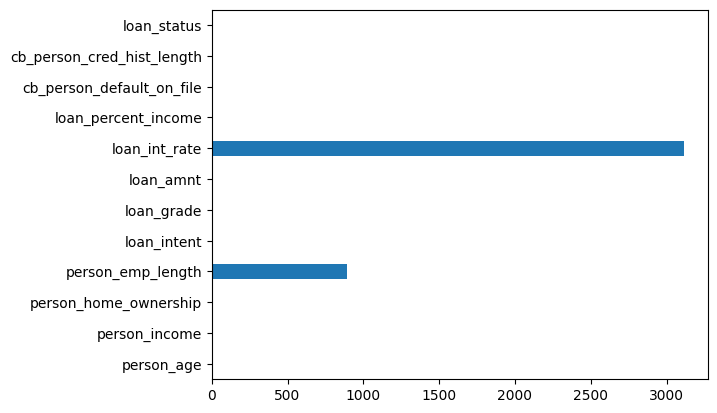

In [17]:
df.isnull().sum().plot(kind='barh')  
plt.show()

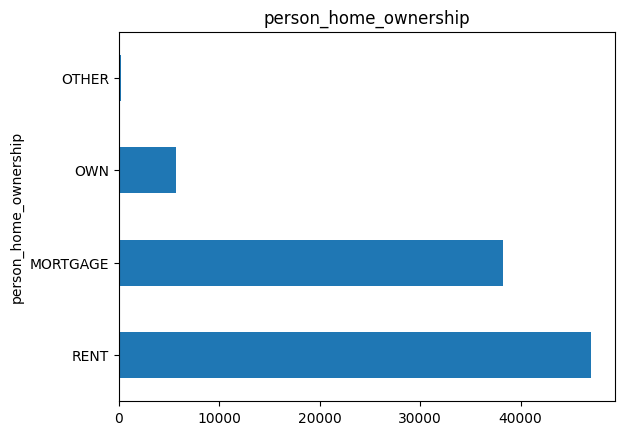

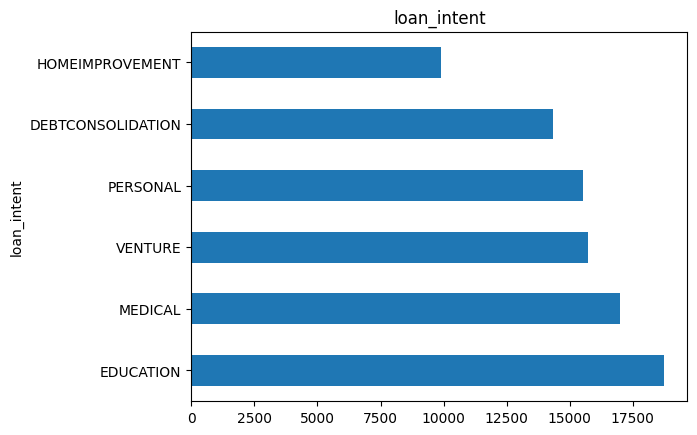

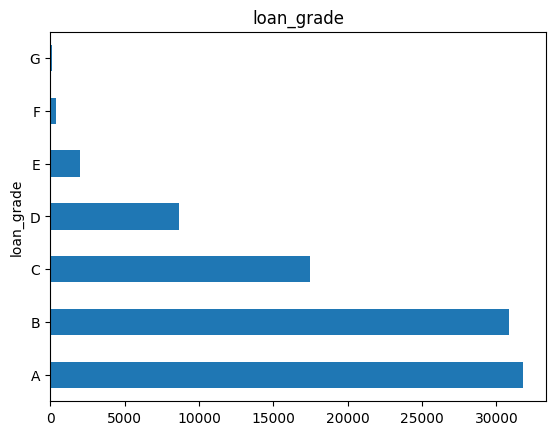

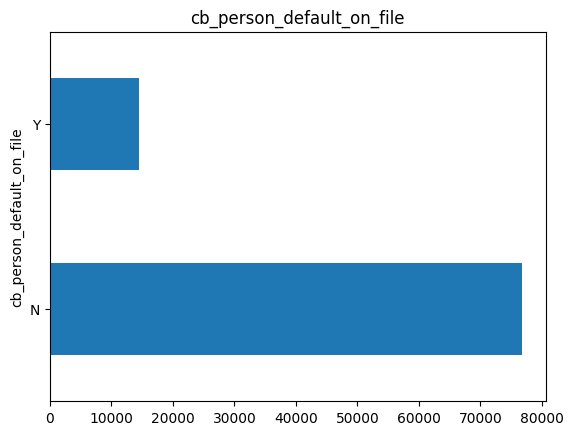

In [18]:
# Select object columns
object_columns = df.select_dtypes(include=['object']).columns

# Plot value counts for each object column
for column in object_columns:
    df[column].value_counts().plot(kind='barh', title=column)
    plt.show()

# Data preprocessing

In [12]:
features = df.drop(['loan_status'], axis=1)
target = df[['loan_status']]

# del df
# gc.collect()

# Feature engineering